# Notes on eye fitting

Summary of the discussion with Petr. All in 2D for now

## Eye

First we have an eye, and there is a pupil. The eye is a disk defined by its centre and
radius. The pupil is defined by the angle on the eye and its length (which would be radius in 3D).

(-100.0, 100.0)

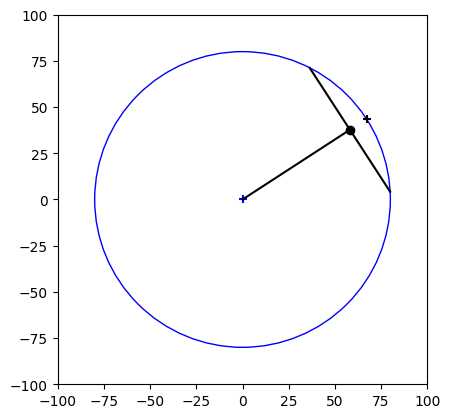

In [1]:
import matplotlib.pyplot as plt
import numpy as np


eye = dict(centre=[0, 0], radius=80, color="blue")
pupil = dict(angle=np.deg2rad(33), radius=40, color="black")


def find_pupil(eye_center, eye_radius, pupil_angle, pupil_radius):
    out = dict()
    pupil_axis = (
        np.array([np.cos(pupil_angle), np.sin(pupil_angle)]) * eye_radius - eye_center
    )
    out["on_eye"] = pupil_axis
    # with the https://en.wikipedia.org/wiki/Intersecting_chords_theorem we can find the
    # centre of the chord
    pupil_to_centre = np.sqrt(eye_radius**2 - pupil_radius**2)
    pupil_centre = (
        np.array([np.cos(pupil_angle), np.sin(pupil_angle)]) * pupil_to_centre
        - eye_center
    )
    out["centre"] = pupil_centre
    for side, sign in zip(["left", "right"], [1, -1]):
        out[side] = (
            pupil_centre
            + np.array(
                [
                    np.cos(pupil_angle + sign * np.pi / 2),
                    np.sin(pupil_angle + sign * np.pi / 2),
                ]
            )
            * pupil_radius
        )
    return out


pupil.update(
    find_pupil(
        eye_center=eye["centre"],
        eye_radius=eye["radius"],
        pupil_angle=pupil["angle"],
        pupil_radius=pupil["radius"],
    )
)


def plot_eye(ax, eye, pupil):
    eye_circle = plt.Circle(
        eye["centre"], eye["radius"], facecolor="None", edgecolor=eye["color"]
    )

    ax.add_artist(eye_circle)
    ax.scatter(eye["centre"][0], eye["centre"][1], marker="+", color=eye["color"])
    ax.scatter(pupil["centre"][0], pupil["centre"][1], marker="o", color=pupil["color"])
    ax.scatter(pupil["on_eye"][0], pupil["on_eye"][1], marker="+", color=pupil["color"])

    ax.plot(
        [pupil["left"][0], pupil["right"][0]],
        [pupil["left"][1], pupil["right"][1]],
        color=pupil["color"],
    )
    ax.plot(
        [eye["centre"][0], pupil["centre"][0]],
        [eye["centre"][1], pupil["centre"][1]],
        color=pupil["color"],
    )


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)


# Camera

We have a camera, let's put it just below the eye for now

(-3.0, 2.0)

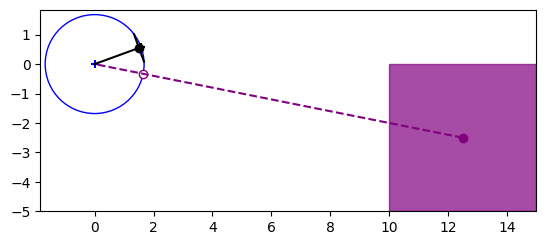

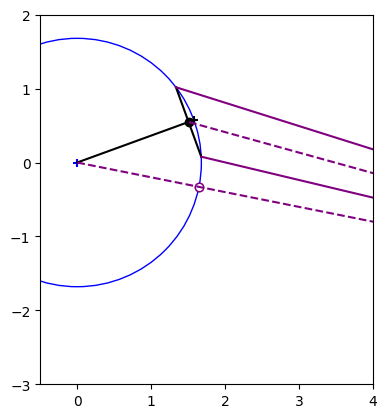

In [2]:
camera = dict(bottom_left=np.array([10, -5]), width=5, height=5, color="purple")
eye = dict(centre=[0, 0], radius=3.36 / 2, color="blue")
pupil = dict(angle=np.deg2rad(20), radius=0.5, color="black")

pupil.update(
    find_pupil(
        eye_center=eye["centre"],
        eye_radius=eye["radius"],
        pupil_angle=pupil["angle"],
        pupil_radius=pupil["radius"],
    )
)
camera["centre"] = camera["bottom_left"] + np.array(
    [camera["width"] / 2, camera["height"] / 2]
)
# find the reflection
# eye circle is x**2 + y**2 = r**2
# line passed by 0,0 and camera['centre'],
# so y = camera['centre'][1]/camera['centre'][0] x = a x
# x**2 (1 + a**2) = r**2
# x = +/- np.sqrt(r**2 / (1 + a**2)) negative being inside the mouse
# y = a * np.sqrt(r**2 / (1 + a**2))
a = camera["centre"][1] / camera["centre"][0]
x_r = np.sqrt(eye["radius"] ** 2 / (1 + a**2))
y_r = x_r * a
reflection = [x_r, y_r]
eye["reflection"] = reflection


def plot_camera(ax, camera, eye=None, pupil=None):
    camera_rect = plt.Rectangle(
        camera["bottom_left"],
        camera["width"],
        camera["height"],
        color=camera["color"],
        alpha=0.7,
    )
    ax.add_artist(camera_rect)
    ax.scatter(camera["centre"][0], camera["centre"][1], color=camera["color"])
    ax.set_xlim(
        min(-eye["radius"] * 1.1, camera["bottom_left"][0]),
        max(eye["radius"] * 1.1, camera["bottom_left"][0] + camera["width"]),
    )
    ax.set_ylim(
        min(-eye["radius"] * 1.1, camera["bottom_left"][1]),
        max(eye["radius"] * 1.1, camera["bottom_left"][1] + camera["height"]),
    )

    if eye is not None:
        ax.plot(
            [camera["centre"][0], eye["centre"][0]],
            [camera["centre"][1], eye["centre"][1]],
            color=camera["color"],
            ls="--",
        )
        ax.scatter(
            eye["reflection"][0],
            eye["reflection"][1],
            edgecolor=camera["color"],
            facecolor="w",
        )

    if pupil is not None:
        for what in ["left", "right", "centre"]:
            ax.plot(
                [camera["centre"][0], pupil[what][0]],
                [camera["centre"][1], pupil[what][1]],
                color=camera["color"],
                ls="--" if what == "centre" else "-",
            )
    return camera_rect


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
plot_camera(ax, camera, eye=eye)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
plot_camera(ax, camera, eye=eye, pupil=pupil)
ax.scatter(x_r, y_r, edgecolor=camera["color"], facecolor="w")
ax.set_xlim(-0.5, 4)
ax.set_ylim(-3, 2)


# Now add the img plane

(-4.0, 1.5)

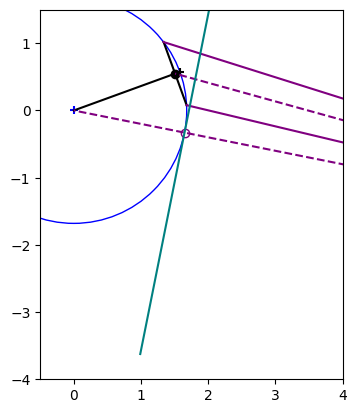

In [3]:
# use sin as we are always on the right half
angle_to_camera = np.arcsin(reflection[1] / eye["radius"])
img_plane = dict(color="teal")
for side, sign in zip(["left", "right"], [1, -1]):
    img_plane[side] = (
        reflection
        + np.array(
            [
                np.cos(angle_to_camera + sign * np.pi / 2),
                np.sin(angle_to_camera + sign * np.pi / 2),
            ]
        )
        * eye["radius"]
        * 2
    )


def plot_image_plane(ax, img_plane):
    ax.plot(
        [img_plane["left"][0], img_plane["right"][0]],
        [img_plane["left"][1], img_plane["right"][1]],
        color=img_plane["color"],
    )


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
plot_camera(ax, camera, eye=eye, pupil=pupil)
plot_image_plane(ax, img_plane)
ax.set_xlim(-0.5, 4)
ax.set_ylim(-4, 1.5)


# Find the radius

The aim is to find $\theta$ the angle of gaze relative to the camera

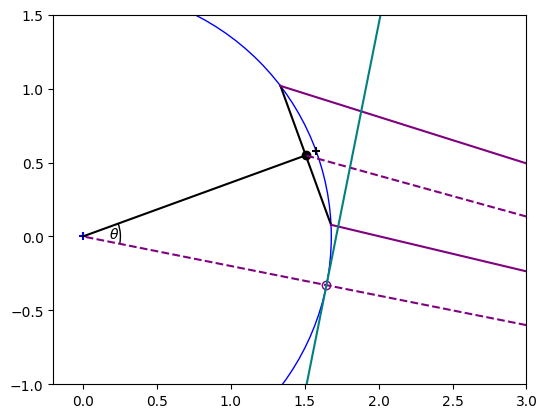

In [4]:
from cottage_analysis.utilities.plot_utils import AngleAnnotation

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
plot_eye(ax, eye, pupil)
plot_camera(ax, camera, eye=eye, pupil=pupil)
plot_image_plane(ax, img_plane)
ax.set_xlim(-0.2, 3)
ax.set_ylim(-1, 1.5)

theta = AngleAnnotation(
    [0, 0], eye["reflection"], pupil["centre"], ax=ax, text=r"$\theta$"
)

ax.plot([pupil['centre'][0], eye['reflection'][0]], 
        [pupil['centre'][0], eye['reflection'][0]])


Intersecting chord says that $r^2 - d^2 = |p_1p_2|$